# NAFNet Online Demo on Image Debluring

## Git clone [NAFNet](https://github.com/megvii-research/NAFNet) repo

In [ ]:
# Mount Google Drive at First
from google.colab import drive
drive.mount('/content/drive')
# Google Drive Starts by /content/drive/MyDrive/[user-specific-file]
%cd /content/drive/MyDrive/ECE253-Code

Mounted at /content/drive
/content/drive/MyDrive/ECE253-Code


In [ ]:
# Just to show current directory
%pwd

'/content/drive/MyDrive/ECE253-Code'

In [ ]:
# One-time operation, since codes are cloned in the drive if the this file is not first time run
#!git clone https://github.com/megvii-research/NAFNet

# get into file
%cd NAFNet

/content/drive/MyDrive/ECE253-Code/NAFNet


# After Above's Operation, directory should be: /content/drive/MyDrive/ECE253-Code/NAFNet

## Set up the enviroment

In [ ]:
# Unfortunately, we have to install environment each time we open the file
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 27.3 MB/s eta 0:00:00
/usr/local/lib/python3.12/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.12/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

      

## Download pretrained models

In [ ]:
# One-time operation to download pre-trained weights to drive
import gdown
gdown.download('https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X
From (redirected): https://drive.google.com/uc?id=14D4V4raNYIOhETfcuuLI3bGLB-OYIv6X&confirm=t&uuid=abb9ab6f-fcce-45c0-85d1-7481157682fe
To: /content/drive/MyDrive/ECE253-Code/NAFNet/experiments/pretrained_models/NAFNet-REDS-width64.pth
100%|██████████| 272M/272M [00:05<00:00, 54.2MB/s]


'./experiments/pretrained_models/NAFNet-REDS-width64.pth'

## Download Demo Image

In [ ]:
# One-time operation to download demo images to drive
gdown.download('https://drive.google.com/uc?id=1kWjrGsAvh4gOA_gn7rB9vnnQVfRINwEn', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/uc?id=1xdfmGUKNDXtnWakyxcGq2nh8m18vHhSI', "demo_input/", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1kWjrGsAvh4gOA_gn7rB9vnnQVfRINwEn
To: /content/drive/MyDrive/ECE253-Code/NAFNet/demo_input/blurry-reds-0.jpg
100%|██████████| 48.9k/48.9k [00:00<00:00, 19.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xdfmGUKNDXtnWakyxcGq2nh8m18vHhSI
To: /content/drive/MyDrive/ECE253-Code/NAFNet/demo_input/blurry-reds-1.jpg
100%|██████████| 37.2k/37.2k [00:00<00:00, 33.6MB/s]


'demo_input/blurry-reds-1.jpg'

## Preparation

In [ ]:
# basic pipeline of the model
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)


## Create Model

In [ ]:
opt_path = 'options/test/REDS/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

 load net keys <built-in method keys of dict object at 0x7e759106bd40>


# Inference and Show results

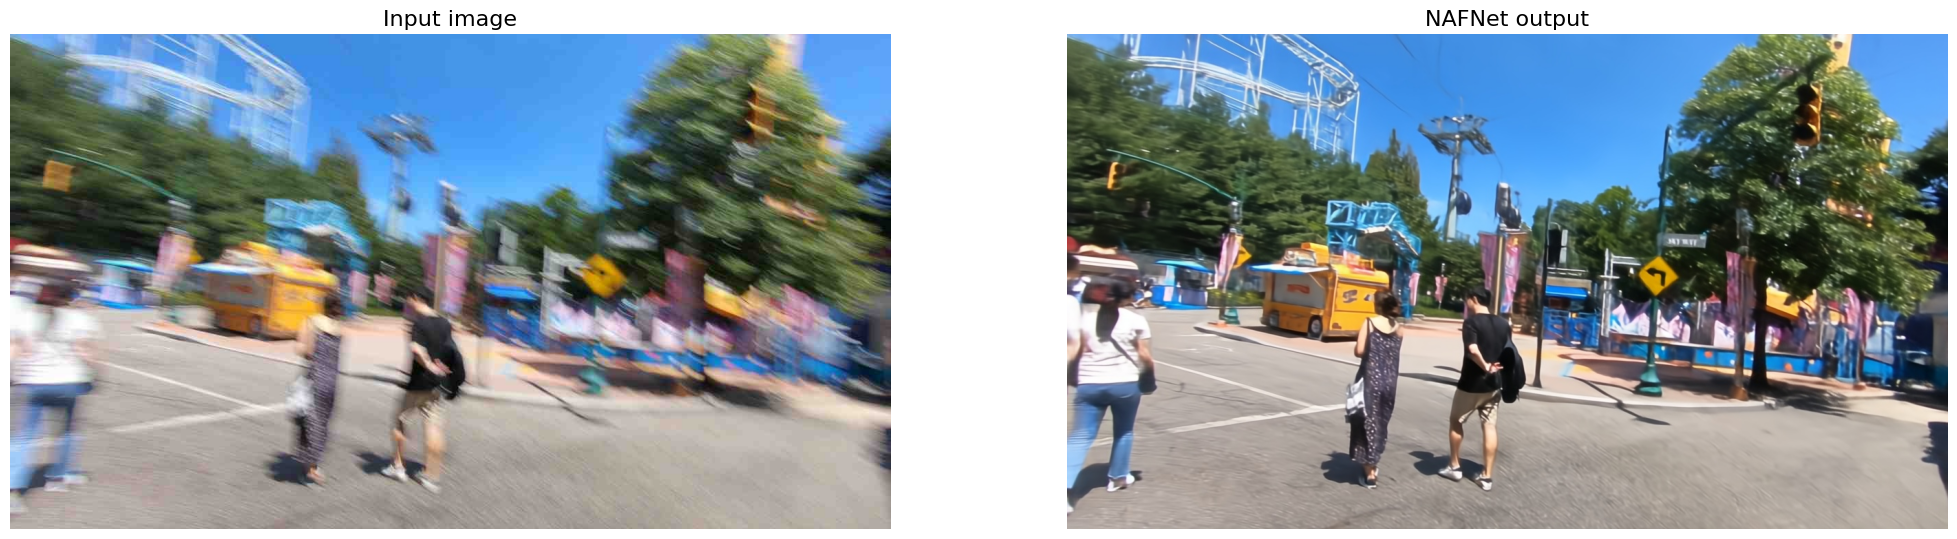

In [ ]:
input_path = 'demo_input/blurry-reds-0.jpg'
output_path = 'demo_output/blurry-reds-0.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

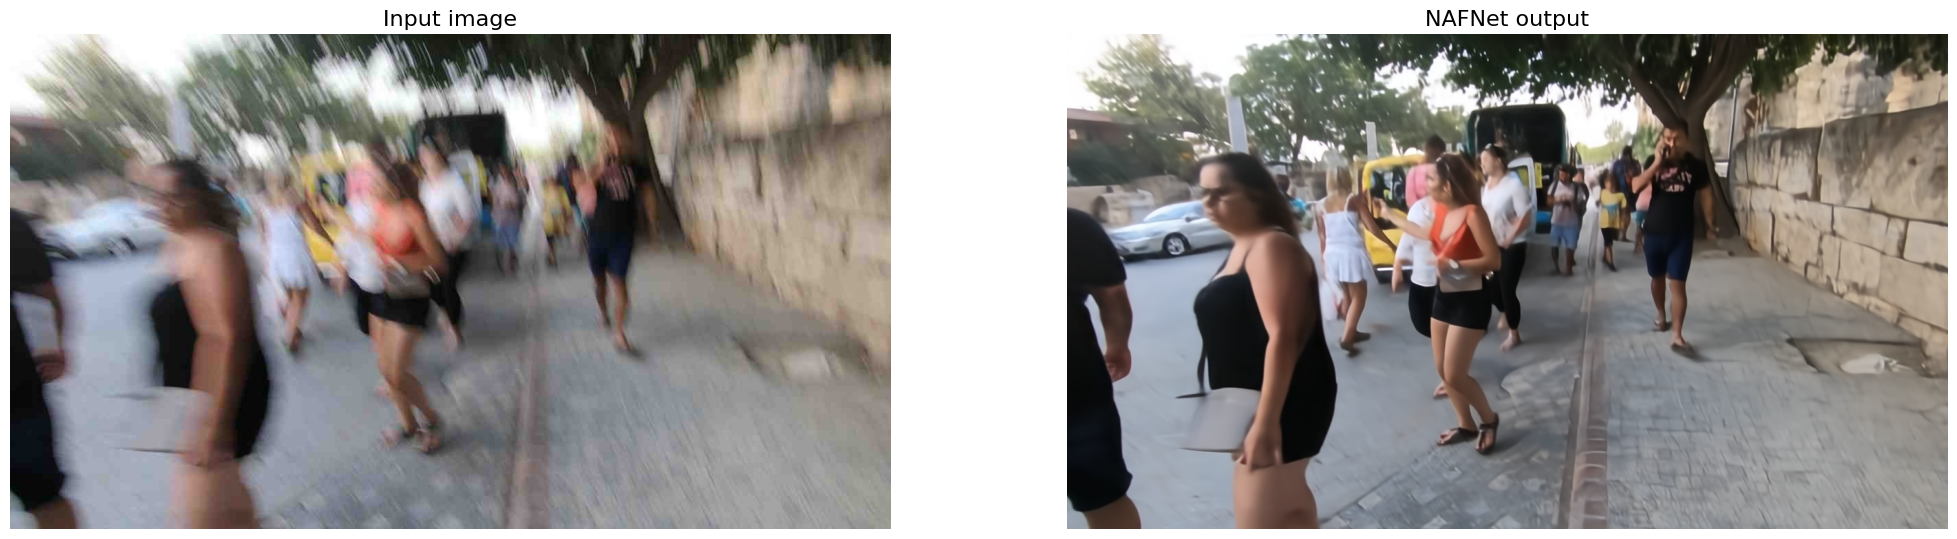

In [ ]:
input_path = 'demo_input/blurry-reds-1.jpg'
output_path = 'demo_output/blurry-reds-1.jpg'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

# Try it on uploaded images

## 1. Load Images

In [ ]:
import os
from google.colab import files
import shutil

upload_folder = '/content/drive/MyDrive/ECE253-Dataset/Motion-Blur/images'
result_folder = '/content/drive/MyDrive/ECE253-Dataset/Motion-Blur-NAFNet-Enhance/images'

## 1.1 Upload From Local (Optional)
## DO NOT RUN This If You Use Google Drive Only

In [ ]:
#remove old folders if already exist
if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
#create new empty folder with same name and same path
os.makedirs(upload_folder)
os.makedirs(result_folder)

#upload images if upload from local
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

## 2. Inference

In [ ]:
import glob
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  inp = img2tensor(img_input)
  output_path = os.path.join(result_folder, os.path.basename(input_path))
  single_image_inference(NAFNet, inp, output_path)

## 3. Visualize (Optional)

In [ ]:
# visualize
input_list = sorted(glob.glob(os.path.join(upload_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)

## 4. Download results

In [ ]:
# download the result
print(f'Download {result_folder}')
os.system(f'zip -r -j download.zip {result_folder}/*')
files.download("download.zip")